# TP2 : Classification de texte avec sklearn

# Part 1:

1. Imports and setup

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import make_scorer, accuracy_score, f1_score

2. Load and preprocess dataset

In [2]:
# Load the provided spam.csv
df = pd.read_csv("spam.csv", encoding="latin-1")

# Drop any rows with missing values
df = df.dropna(subset=["text", "label"])

# Make sure text is treated as string
df["text"] = df["text"].astype(str)

# Strip unwanted characters and lowercase text
def preprocess(text):
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    return text.lower().strip()

df["text_clean"] = df["text"].apply(preprocess)

# Remove any rows where text is now empty
df = df[df["text_clean"].str.strip() != ""]


3. Fonction de vectorisation et evaluation

In [3]:
def vectorize_and_evaluate(vectorizer, name):
    X = vectorizer.fit_transform(df["text_clean"])
    y = df["label"].astype(int)
    
    models = {
        "LogisticRegression": LogisticRegression(max_iter=1000),
        "RandomForest": RandomForestClassifier(n_estimators=100),
        "MLP": MLPClassifier(max_iter=300)
    }

    results = {}
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    for model_name, model in models.items():
        acc = cross_val_score(model, X, y, cv=skf, scoring=make_scorer(accuracy_score)).mean()
        f1 = cross_val_score(model, X, y, cv=skf, scoring=make_scorer(f1_score)).mean()
        results[model_name] = {"accuracy": acc, "f1_score": f1}
        print(f"{name} - {model_name}: Accuracy = {acc:.4f}, F1 Score = {f1:.4f}")
    
    return results


4. Executer BoW et TF-IDF

In [4]:
print("Bag of Words (BoW) Results")
bow_vectorizer = CountVectorizer(max_features=5000)
bow_results = vectorize_and_evaluate(bow_vectorizer, "BoW")

print("\nTF-IDF Results")
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
tfidf_results = vectorize_and_evaluate(tfidf_vectorizer, "TF-IDF")


Bag of Words (BoW) Results
BoW - LogisticRegression: Accuracy = 0.9793, F1 Score = 0.9182
BoW - RandomForest: Accuracy = 0.9735, F1 Score = 0.8938
BoW - MLP: Accuracy = 0.9811, F1 Score = 0.9306

TF-IDF Results
TF-IDF - LogisticRegression: Accuracy = 0.9596, F1 Score = 0.8237
TF-IDF - RandomForest: Accuracy = 0.9733, F1 Score = 0.8929
TF-IDF - MLP: Accuracy = 0.9829, F1 Score = 0.9337


5. Performance vs max_features

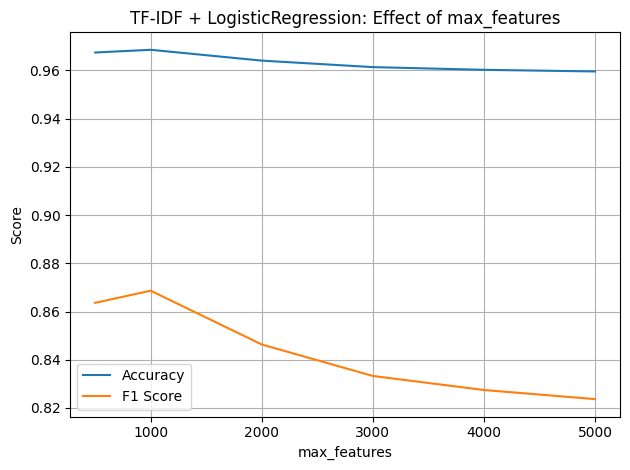

In [5]:
def plot_feature_effects():
    feature_range = [500, 1000, 2000, 3000, 4000, 5000]
    accs, f1s = [], []

    for n in feature_range:
        vec = TfidfVectorizer(max_features=n)
        X = vec.fit_transform(df["text_clean"])
        y = df["label"].astype(int)

        model = LogisticRegression(max_iter=1000)
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        acc = cross_val_score(model, X, y, cv=skf, scoring=make_scorer(accuracy_score)).mean()
        f1 = cross_val_score(model, X, y, cv=skf, scoring=make_scorer(f1_score)).mean()

        accs.append(acc)
        f1s.append(f1)

    plt.plot(feature_range, accs, label="Accuracy")
    plt.plot(feature_range, f1s, label="F1 Score")
    plt.xlabel("max_features")
    plt.ylabel("Score")
    plt.title("TF-IDF + LogisticRegression: Effect of max_features")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_feature_effects()


# Part2:

1. Re-imports and load data

In [6]:
import pandas as pd
import numpy as np
import re

# Charger les données
df = pd.read_csv("spam.csv", encoding="latin-1")
df = df.dropna(subset=["text", "label"])
df["text"] = df["text"].astype(str)

# Nettoyage de texte
def preprocess(text):
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    return text.lower().strip()

df["text_clean"] = df["text"].apply(preprocess)
df = df[df["text_clean"].str.strip() != ""]

y = df["label"].astype(int)


2. Generation des embeddings

In [7]:
from sentence_transformers import SentenceTransformer

# Utiliser un modèle léger et compatible CPU
model = SentenceTransformer("all-MiniLM-L6-v2")

# Convertir chaque texte en vecteur
X_embeddings = model.encode(df["text_clean"].tolist(), show_progress_bar=True)


c:\Users\Admin\Desktop\UdeM\Winter2025\IFT3335 - Intelligence Artificielle\TPs\AI-TP2\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\Admin\Desktop\UdeM\Winter2025\IFT3335 - Intelligence Artificielle\TPs\AI-TP2\.venv\Lib\site-packages\huggingface_hub\file_download.py:144: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Admin\.cache\huggingface\hub\models--sentence-transformers--all-MiniLM-L6-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To suppor

3. Entrainement et evaluation des modeles

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import make_scorer, accuracy_score, f1_score

models = {
    "LogisticRegression": LogisticRegression(max_iter=1000),
    "RandomForest": RandomForestClassifier(n_estimators=100),
    "MLP": MLPClassifier(max_iter=300)
}

results_embeddings = {}
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, model in models.items():
    acc = cross_val_score(model, X_embeddings, y, cv=skf, scoring=make_scorer(accuracy_score)).mean()
    f1 = cross_val_score(model, X_embeddings, y, cv=skf, scoring=make_scorer(f1_score)).mean()
    results_embeddings[name] = {"accuracy": acc, "f1_score": f1}
    print(f"Embeddings - {name}: Accuracy = {acc:.4f}, F1 Score = {f1:.4f}")


Embeddings - LogisticRegression: Accuracy = 0.9690, F1 Score = 0.8753
Embeddings - RandomForest: Accuracy = 0.9574, F1 Score = 0.8079
Embeddings - MLP: Accuracy = 0.9818, F1 Score = 0.9329
